# This is a toy example of imagenet-face-obfuscation.

### I used MTCNN from facenet_pytorch to detect a face and original blur code from imagenet-face-obfuscation.

## Define Preprocess class to extract bounding box.

In [1]:
## This code is based on https://github.com/timesler/facenet-pytorch/
import numpy as np
from facenet_pytorch import MTCNN

def extract(bbox, width, height, margin=0.2) -> None:
    margin = [
        margin * (bbox[2] - bbox[0]),
        margin * (bbox[3] - bbox[1]),
    ]
    bbox = [
        int(max(bbox[0] - margin[0] / 2, 0)),
        int(max(bbox[1] - margin[1] / 2, 0)),
        int(min(bbox[2] + margin[0] / 2, width)),
        int(min(bbox[3] + margin[1] / 2, height)),
    ]
    return bbox

class Preprocess:
    def __init__(self, device='cpu'):
        self.detector = MTCNN(device=device)
        self.detector.eval()
        self.bbox = None
        
    def __call__(self, img):
        height, width,_ = img.shape
        if self.bbox == None:
            box = self.detect(img)
            if isinstance(box, np.ndarray):
                self.bbox = extract(box[0], width, height)
            else:
                return None
        cropped = img[self.bbox[1]:self.bbox[3],self.bbox[0]:self.bbox[2]]
        return cropped, self.bbox
        
    def detect(self, img):
        bbox_list, _ = self.detector.detect(img)
        return bbox_list


## Define blur function to blur a face.

In [2]:
## This code is based on https://github.com/princetonvisualai/imagenet-face-obfuscation
## Copyright (c) 2021, Princeton Visual AI Lab
## All rights reserved.
from PIL import Image, ImageDraw, ImageFilter

def blur(img, bbox):
    """
    Apply a variant of Gaussian blurring.
    See the appendix for detail.
    """
    mask = Image.new(mode="L", size=img.size, color="white")
    max_diagonal = 0

    diagonal = max(bbox["x1"] - bbox["x0"], bbox["y1"] - bbox["y0"])
    max_diagonal = max(max_diagonal, diagonal)
    bbox = [
        bbox["x0"] - 0.1 * diagonal,
        bbox["y0"] - 0.1 * diagonal,
        bbox["x1"] + 0.1 * diagonal,
        bbox["y1"] + 0.1 * diagonal,
    ]
    draw = ImageDraw.Draw(mask)
    draw.rectangle(bbox, fill="black")

    blurred_img = img.filter(ImageFilter.GaussianBlur(0.1 * max_diagonal))
    blurred_mask = mask.filter(ImageFilter.GaussianBlur(0.1 * max_diagonal))
    img = Image.composite(img, blurred_img, blurred_mask)
    return img


## Load an original image with a face.

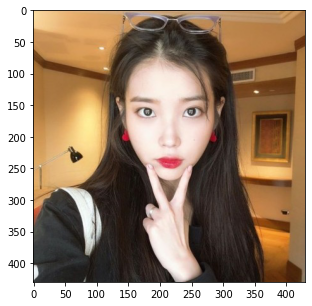

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

path = './src/IU.JPEG'
img = Image.open(path).convert("RGB")

figure = plt.figure(figsize=(5,5))
plt.imshow(img)

## Extract the bounding box using MTCNN (Preprocess).

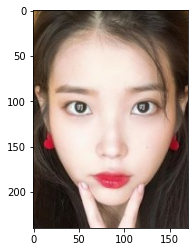

In [4]:
bbox = {}
preprocess = Preprocess()
cropped_img, (bbox["x0"], bbox["y0"], bbox["x1"], bbox["y1"]) = preprocess(np.array(img))
plt.imshow(cropped_img)

## Make a blurred image!

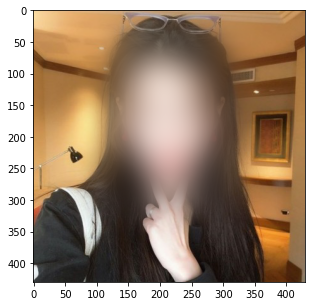

In [5]:
blurred_img = blur(img, bbox)
figure = plt.figure(figsize=(5,5))
plt.imshow(blurred_img)